We noticed that the performance of the model significantly declined with the augmentation.
Therefore we are going to run perfoprmance gradient on the model trained on unaugmented data and then compare results

In [ ]:
#@title
# Import files
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet, efficientnet, mobilenet_v2
from tensorflow.keras import Model

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow

from os import listdir
from os.path import isfile, join
import numpy
import cv2

import pandas as pd
import imgaug.augmenters as iaa

# import test, train, and validation folders:
import skimage

from keras.models import model_from_json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.2/191.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyashukla01","key":"b0652e31cce9e0350fd087c244990d74"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

 95% 113M/119M [00:01<00:00, 93.7MB/s]
100% 119M/119M [00:01<00:00, 88.5MB/s]


In [ ]:
! unzip -qq chest-ctscan-images.zip

In [ ]:
# Load VGG model from json

#Load the Model from Json File
json_file = open('/content/gdrive/My Drive/SML_Project/model_vgg16.json', 'r')
model_json_c = json_file.read()
json_file.close()
model = model_from_json(model_json_c)
#Load the weights
model.load_weights("/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-VGG16.hdf5")
#Compile the model
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# Gradient Functions

In [ ]:
# Decrease Image Contrast 
def Contrast(images, contrast_control,):
  """ 
    image - the original input image.
    alpha - the contrast value. Lower contrast, use 0 < alpha < 1. Higher contrast use alpha > 1.
  """ 
  contrasted_images = []
  for i in range(len(images)): 
    adjusted = cv2.convertScaleAbs(images[i], alpha = contrast_control,)
    contrasted_images.append(adjusted)
  return contrasted_images

# Lower Contrast Images

In [ ]:
# Directories for image contrast dataset
! mkdir altered_pixel_intensity_images
! mkdir altered_pixel_intensity_images/contrast/
! mkdir altered_pixel_intensity_images/contrast/0
! mkdir altered_pixel_intensity_images/contrast/0/cancerous
! mkdir altered_pixel_intensity_images/contrast/0/non_cancerous
! mkdir altered_pixel_intensity_images/contrast/1
! mkdir altered_pixel_intensity_images/contrast/1/cancerous
! mkdir altered_pixel_intensity_images/contrast/1/non_cancerous
! mkdir altered_pixel_intensity_images/contrast/2
! mkdir altered_pixel_intensity_images/contrast/2/cancerous
! mkdir altered_pixel_intensity_images/contrast/2/non_cancerous
! mkdir altered_pixel_intensity_images/contrast/3
! mkdir altered_pixel_intensity_images/contrast/3/cancerous
! mkdir altered_pixel_intensity_images/contrast/3/non_cancerous

In [ ]:
# Create a new dataset with cancerous and non cancerous images
! mkdir ct_scan

! mkdir ct_scan/test
! mkdir ct_scan/test/cancerous
! mkdir ct_scan/test/non_cancerous
! cp -r Data/test/adenocarcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/large.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/squamous.cell.carcinoma/. ct_scan/test/cancerous/
! cp -r Data/test/normal/. ct_scan/test/non_cancerous/

In [ ]:
cancer_test_path = "ct_scan/test/cancerous/"
noncancer_test_path = "ct_scan/test/non_cancerous/"

In [ ]:
# Test - Cancer Lower Contrast Images  
images = []
for path in os.listdir(cancer_test_path):
  image_ = cv2.imread(cancer_test_path+'/'+path)
  images.append(image_)

contrast_control = [0.2, 0.4, 0.6, 0.8] # factors between 0 and 1 lower image contrast 
for j in range(len(contrast_control)): 
  count = 0 
  contrasted_images = Contrast(images, contrast_control[j])
  for i in range(len(contrasted_images)):
      contrasted_image = contrasted_images[i]
      cv2.imwrite(f"altered_pixel_intensity_images/contrast/{j}/cancerous/{i}.jpg",contrasted_image)
      count +=1
      k = cv2.waitKey(1000)
  print(f"Number of Contrasted Cancer Images of Contrast Factor = {contrast_control[j]} : {count}")

# Test - Non Cancer Lower Contrast Images  
images = []
for path in os.listdir(noncancer_test_path):
  image_ = cv2.imread(noncancer_test_path+'/'+path)
  images.append(image_)

contrast_control = [0.2, 0.4, 0.6, 0.8] # factors between 0 and 1 lower image contrast 
for j in range(len(contrast_control)): 
  count = 0 
  contrasted_images = Contrast(images, contrast_control[j])
  for i in range(len(contrasted_images)):
      contrasted_image = contrasted_images[i]
      cv2.imwrite(f"altered_pixel_intensity_images/contrast/{j}/non_cancerous/{i}.jpg",contrasted_image)
      count +=1
      k = cv2.waitKey(1000)
  print(f"Number of Contrasted Non Cancer Images of Contrast Factor = {contrast_control[j]} : {count}")

Number of Contrasted Cancer Images of Contrast Factor = 0.2 : 224
Number of Contrasted Cancer Images of Contrast Factor = 0.4 : 224
Number of Contrasted Cancer Images of Contrast Factor = 0.6 : 224
Number of Contrasted Cancer Images of Contrast Factor = 0.8 : 224
Number of Contrasted Non Cancer Images of Contrast Factor = 0.2 : 54
Number of Contrasted Non Cancer Images of Contrast Factor = 0.4 : 54
Number of Contrasted Non Cancer Images of Contrast Factor = 0.6 : 54
Number of Contrasted Non Cancer Images of Contrast Factor = 0.8 : 54


In [ ]:
# testgenerator for contrast

N_CLASSES = 2
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(dtype='float32')
test_losses_contrast = []
test_accuracy_list_contrast = []
for i in range(len(contrast_control)):
  test_path = f"altered_pixel_intensity_images/contrast/{i}"
  test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
  test_loss, test_accuracy = model.evaluate(test_generator)
  test_losses_contrast.append(test_loss)
  test_accuracy_list_contrast.append(test_accuracy)
  print(test_losses_contrast)
  print(test_accuracy_list_contrast)

Found 278 images belonging to 2 classes.
9/9 [==============================] - 672s 73s/step - loss: 1.2185 - accuracy: 0.2014
[1.2185466289520264]
[0.20143884420394897]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 659s 73s/step - loss: 1.5737 - accuracy: 0.2122
[1.2185466289520264, 1.573679804801941]
[0.20143884420394897, 0.21223022043704987]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 654s 72s/step - loss: 1.9346 - accuracy: 0.2230
[1.2185466289520264, 1.573679804801941, 1.9346104860305786]
[0.20143884420394897, 0.21223022043704987, 0.22302158176898956]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 650s 72s/step - loss: 2.3008 - accuracy: 0.2302
[1.2185466289520264, 1.573679804801941, 1.9346104860305786, 2.300842761993408]
[0.20143884420394897, 0.21223022043704987, 0.22302158176898956, 0.23021583259105682]


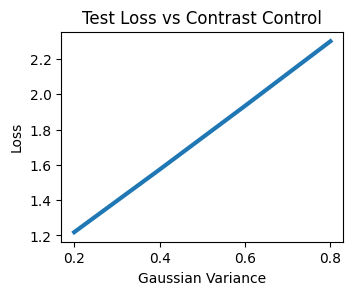

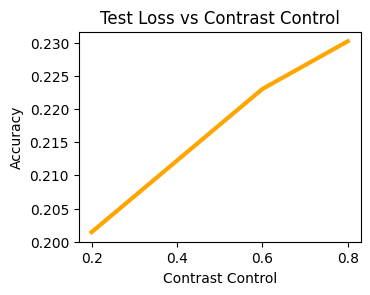

In [ ]:
# Graph for the trend


# plot loss vs Contrast Control
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(contrast_control, test_losses_contrast, linewidth=3)
plt.title('Test Loss vs Contrast Control')
plt.xlabel('Gaussian Variance')
plt.ylabel('Loss')
plt.show()

# plot accuracy vs Contrast Control
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(contrast_control, test_accuracy_list_contrast, color = "orange", linewidth=3)
plt.title('Test Loss vs Contrast Control')
plt.xlabel('Contrast Control')
plt.ylabel('Accuracy')
plt.show()

ResNet50 trained in augmented data

In [ ]:
# Load ResNet model from json

#Load the Model from Json File
json_file = open('/content/gdrive/My Drive/SML_Project/model_resnet50_augmented.json', 'r')
model_json_c = json_file.read()
json_file.close()
model_r = model_from_json(model_json_c)
#Load the weights
model_r.load_weights("/content/gdrive/My Drive/SML_Project/chest_CT_SCAN-ResNet50_augmented.hdf5")
#Compile the model
opt = SGD(lr=1e-4, momentum=0.9)
model_r.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
# testgenerator for contrast

N_CLASSES = 2
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(dtype='float32')
test_losses_contrast_r = []
test_accuracy_list_contrast_r = []
for i in range(len(contrast_control)):
  test_path = f"altered_pixel_intensity_images/contrast/{i}"
  test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')
  test_loss, test_accuracy = model_r.evaluate(test_generator)
  test_losses_contrast_r.append(test_loss)
  test_accuracy_list_contrast_r.append(test_accuracy)
  print(test_losses_contrast_r)
  print(test_accuracy_list_contrast_r)

Found 278 images belonging to 2 classes.
9/9 [==============================] - 252s 28s/step - loss: 0.2348 - accuracy: 0.8741
[0.2348148673772812]
[0.8741007447242737]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 235s 26s/step - loss: 0.1373 - accuracy: 0.9532
[0.2348148673772812, 0.1373186856508255]
[0.8741007447242737, 0.9532374143600464]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 238s 26s/step - loss: 0.0884 - accuracy: 0.9964
[0.2348148673772812, 0.1373186856508255, 0.08841878175735474]
[0.8741007447242737, 0.9532374143600464, 0.9964028596878052]
Found 278 images belonging to 2 classes.
9/9 [==============================] - 239s 27s/step - loss: 0.0852 - accuracy: 0.9964
[0.2348148673772812, 0.1373186856508255, 0.08841878175735474, 0.08516090363264084]
[0.8741007447242737, 0.9532374143600464, 0.9964028596878052, 0.9964028596878052]


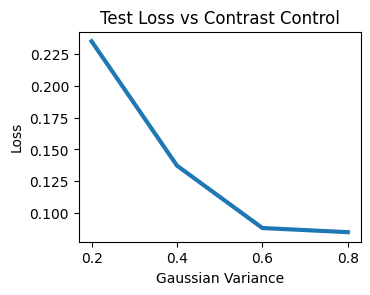

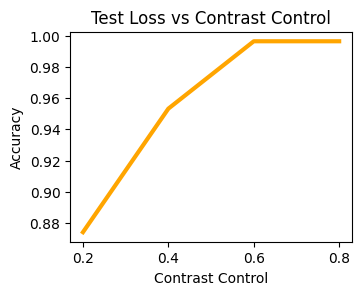

In [ ]:
# Graph for the trend


# plot loss vs Contrast Control
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(contrast_control, test_losses_contrast_r, linewidth=3)
plt.title('Test Loss vs Contrast Control')
plt.xlabel('Gaussian Variance')
plt.ylabel('Loss')
plt.show()

# plot accuracy vs Contrast Control
plt.figure(figsize=(8,6))
plt.subplot(222)
plt.plot(contrast_control, test_accuracy_list_contrast_r, color = "orange", linewidth=3)
plt.title('Test Loss vs Contrast Control')
plt.xlabel('Contrast Control')
plt.ylabel('Accuracy')
plt.show()